# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:08<00:00, 7.09KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

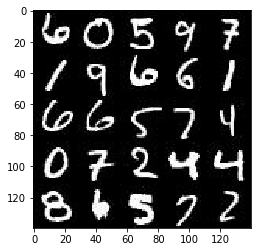

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

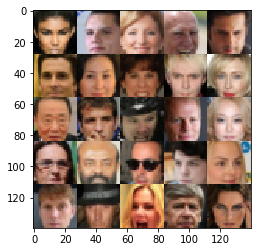

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [168]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [248]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [249]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # 28x28ximage_channels now
        
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        lrelu1 = tf.maximum(alpha * conv1, conv1)
        # 14x14x64 now
        
        conv2 = tf.layers.conv2d(lrelu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128 now
        
        conv3 = tf.layers.conv2d(lrelu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256 now
        
        flat = tf.reshape(lrelu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [250]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        flat = tf.layers.dense(z, 7*7*256)
        inputs = tf.reshape(flat, (-1, 7, 7, 256))
        bn1 = tf.layers.batch_normalization(inputs, training=is_train)
        lrelu1 = tf.maximum(alpha * bn1, bn1)
        # 7x7x256 now
        
        deconv2 = tf.layers.conv2d_transpose(lrelu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(deconv2, training=is_train)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        # 14x14x128 now
        
        deconv3 = tf.layers.conv2d_transpose(lrelu2, 64, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(deconv3, training=is_train)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        # 28x28x64 now
        
        logits = tf.layers.conv2d_transpose(lrelu3, out_channel_dim, 5, strides=1, padding='same')
        output = tf.tanh(logits)
        # 28x28xoutput_channel_dim now
    
    return output



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [251]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_output = generator(input_z, out_channel_dim)
    d_output_real, d_logits_real = discriminator(input_real)
    d_output_fake, d_logits_fake = discriminator(g_output, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, labels=tf.ones_like(d_output_real) * 0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_output_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_output_fake)))
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [252]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # CAUTION: YOU NEED THIS WITH CLAUSE
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [253]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [254]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    tf.reset_default_graph()
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    step = 0
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                
                # Scale from (-0.5, 0.5) to (-1, 1)
                batch_images = batch_images * 2
                
                # Sample randome noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                             
                if step % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_real: batch_images, input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if step % 100 == 0:
                    show_generator_output(sess, n_images, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6529... Generator Loss: 3.9016
Epoch 1/2... Discriminator Loss: 2.6421... Generator Loss: 10.0037
Epoch 1/2... Discriminator Loss: 2.8513... Generator Loss: 3.8245
Epoch 1/2... Discriminator Loss: 2.3014... Generator Loss: 2.9858
Epoch 1/2... Discriminator Loss: 1.8811... Generator Loss: 1.6449
Epoch 1/2... Discriminator Loss: 1.6801... Generator Loss: 1.5660
Epoch 1/2... Discriminator Loss: 1.6043... Generator Loss: 1.4869
Epoch 1/2... Discriminator Loss: 1.5585... Generator Loss: 1.5425
Epoch 1/2... Discriminator Loss: 1.5823... Generator Loss: 1.4344
Epoch 1/2... Discriminator Loss: 1.5237... Generator Loss: 1.3319


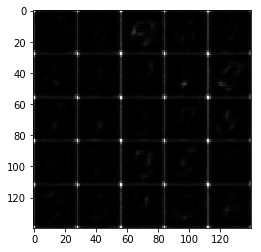

Epoch 1/2... Discriminator Loss: 1.5499... Generator Loss: 1.2189
Epoch 1/2... Discriminator Loss: 1.6122... Generator Loss: 1.3529
Epoch 1/2... Discriminator Loss: 1.5255... Generator Loss: 1.3709
Epoch 1/2... Discriminator Loss: 1.5694... Generator Loss: 1.5562
Epoch 1/2... Discriminator Loss: 1.5107... Generator Loss: 1.4905
Epoch 1/2... Discriminator Loss: 1.3758... Generator Loss: 1.5342
Epoch 1/2... Discriminator Loss: 1.5074... Generator Loss: 1.4497
Epoch 1/2... Discriminator Loss: 1.4953... Generator Loss: 1.5533
Epoch 1/2... Discriminator Loss: 1.4041... Generator Loss: 1.6218
Epoch 1/2... Discriminator Loss: 1.4075... Generator Loss: 1.3699


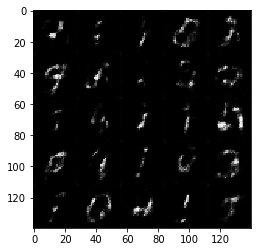

Epoch 1/2... Discriminator Loss: 1.3357... Generator Loss: 1.6244
Epoch 1/2... Discriminator Loss: 1.4997... Generator Loss: 1.7622
Epoch 1/2... Discriminator Loss: 1.2293... Generator Loss: 2.5591
Epoch 1/2... Discriminator Loss: 1.3046... Generator Loss: 1.2762
Epoch 1/2... Discriminator Loss: 1.4358... Generator Loss: 1.3226
Epoch 1/2... Discriminator Loss: 1.4852... Generator Loss: 1.4659
Epoch 1/2... Discriminator Loss: 1.3238... Generator Loss: 1.3959
Epoch 1/2... Discriminator Loss: 1.3842... Generator Loss: 1.4858
Epoch 1/2... Discriminator Loss: 1.4119... Generator Loss: 1.3266
Epoch 1/2... Discriminator Loss: 1.2638... Generator Loss: 1.8087


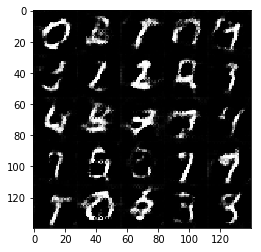

Epoch 1/2... Discriminator Loss: 1.3537... Generator Loss: 1.3128
Epoch 1/2... Discriminator Loss: 1.3611... Generator Loss: 1.4033
Epoch 1/2... Discriminator Loss: 1.2360... Generator Loss: 1.5611
Epoch 1/2... Discriminator Loss: 1.2899... Generator Loss: 1.5256
Epoch 1/2... Discriminator Loss: 1.2684... Generator Loss: 1.5787
Epoch 1/2... Discriminator Loss: 1.3868... Generator Loss: 1.4672
Epoch 1/2... Discriminator Loss: 1.3688... Generator Loss: 1.3942
Epoch 1/2... Discriminator Loss: 1.3830... Generator Loss: 1.3164
Epoch 1/2... Discriminator Loss: 1.3670... Generator Loss: 1.4094
Epoch 1/2... Discriminator Loss: 1.3284... Generator Loss: 1.3490


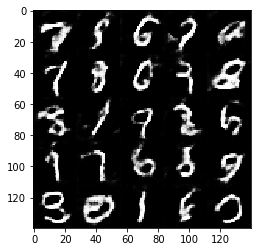

Epoch 1/2... Discriminator Loss: 1.3207... Generator Loss: 1.3566
Epoch 1/2... Discriminator Loss: 1.4682... Generator Loss: 1.3379
Epoch 1/2... Discriminator Loss: 1.3099... Generator Loss: 1.2055
Epoch 1/2... Discriminator Loss: 1.3824... Generator Loss: 1.3230
Epoch 1/2... Discriminator Loss: 1.4605... Generator Loss: 1.2514
Epoch 1/2... Discriminator Loss: 1.3622... Generator Loss: 1.2254
Epoch 2/2... Discriminator Loss: 1.3945... Generator Loss: 1.4822
Epoch 2/2... Discriminator Loss: 1.3479... Generator Loss: 1.3891
Epoch 2/2... Discriminator Loss: 1.4291... Generator Loss: 1.3620
Epoch 2/2... Discriminator Loss: 1.3029... Generator Loss: 1.1742


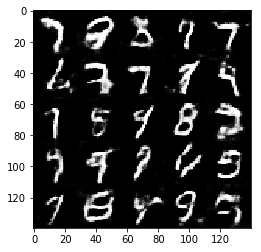

Epoch 2/2... Discriminator Loss: 1.3166... Generator Loss: 1.3462
Epoch 2/2... Discriminator Loss: 1.3537... Generator Loss: 1.3577
Epoch 2/2... Discriminator Loss: 1.4360... Generator Loss: 1.3883
Epoch 2/2... Discriminator Loss: 1.3418... Generator Loss: 1.3525
Epoch 2/2... Discriminator Loss: 1.4177... Generator Loss: 1.4186
Epoch 2/2... Discriminator Loss: 1.2990... Generator Loss: 1.0818
Epoch 2/2... Discriminator Loss: 1.3779... Generator Loss: 1.2523
Epoch 2/2... Discriminator Loss: 1.3519... Generator Loss: 1.1972
Epoch 2/2... Discriminator Loss: 1.4685... Generator Loss: 1.4653
Epoch 2/2... Discriminator Loss: 1.3094... Generator Loss: 1.1719


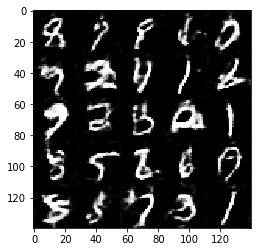

Epoch 2/2... Discriminator Loss: 1.4002... Generator Loss: 1.4148
Epoch 2/2... Discriminator Loss: 1.5034... Generator Loss: 1.4335
Epoch 2/2... Discriminator Loss: 1.3117... Generator Loss: 1.3472
Epoch 2/2... Discriminator Loss: 1.4387... Generator Loss: 1.3896
Epoch 2/2... Discriminator Loss: 1.2888... Generator Loss: 1.1846
Epoch 2/2... Discriminator Loss: 1.4199... Generator Loss: 1.4734
Epoch 2/2... Discriminator Loss: 1.4057... Generator Loss: 1.2572
Epoch 2/2... Discriminator Loss: 1.2461... Generator Loss: 1.0420
Epoch 2/2... Discriminator Loss: 1.3913... Generator Loss: 1.3902
Epoch 2/2... Discriminator Loss: 1.3781... Generator Loss: 1.2525


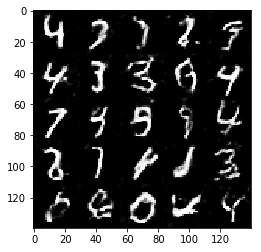

Epoch 2/2... Discriminator Loss: 1.3927... Generator Loss: 1.3281
Epoch 2/2... Discriminator Loss: 1.2328... Generator Loss: 1.2433
Epoch 2/2... Discriminator Loss: 1.4659... Generator Loss: 1.2637
Epoch 2/2... Discriminator Loss: 1.3026... Generator Loss: 1.1831
Epoch 2/2... Discriminator Loss: 1.5722... Generator Loss: 1.5184
Epoch 2/2... Discriminator Loss: 1.2338... Generator Loss: 1.0606
Epoch 2/2... Discriminator Loss: 1.3954... Generator Loss: 1.3593
Epoch 2/2... Discriminator Loss: 1.2611... Generator Loss: 1.0919
Epoch 2/2... Discriminator Loss: 1.2989... Generator Loss: 1.3324
Epoch 2/2... Discriminator Loss: 1.2684... Generator Loss: 1.1472


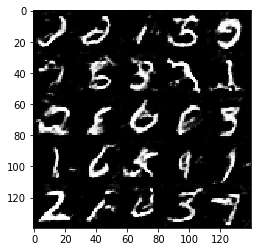

Epoch 2/2... Discriminator Loss: 1.6276... Generator Loss: 1.4804
Epoch 2/2... Discriminator Loss: 1.2156... Generator Loss: 1.2126
Epoch 2/2... Discriminator Loss: 1.2439... Generator Loss: 1.3281
Epoch 2/2... Discriminator Loss: 1.2338... Generator Loss: 1.2030
Epoch 2/2... Discriminator Loss: 1.5056... Generator Loss: 1.6891
Epoch 2/2... Discriminator Loss: 1.2345... Generator Loss: 1.2396
Epoch 2/2... Discriminator Loss: 1.8239... Generator Loss: 1.6667
Epoch 2/2... Discriminator Loss: 1.2159... Generator Loss: 0.9087
Epoch 2/2... Discriminator Loss: 1.2594... Generator Loss: 1.0478
Epoch 2/2... Discriminator Loss: 1.4051... Generator Loss: 1.6166


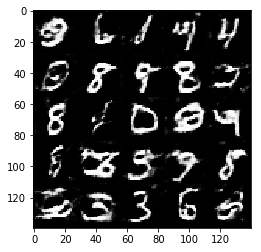

Epoch 2/2... Discriminator Loss: 1.4001... Generator Loss: 1.3090
Epoch 2/2... Discriminator Loss: 1.2951... Generator Loss: 0.7425
Epoch 2/2... Discriminator Loss: 3.0243... Generator Loss: 3.4717


IndexError: list index out of range

In [256]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1280... Generator Loss: 10.7716
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 1.1562
Epoch 1/1... Discriminator Loss: 2.0764... Generator Loss: 3.0181
Epoch 1/1... Discriminator Loss: 1.8600... Generator Loss: 2.6674
Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 3.2231
Epoch 1/1... Discriminator Loss: 0.6997... Generator Loss: 1.3628
Epoch 1/1... Discriminator Loss: 0.9771... Generator Loss: 2.6343
Epoch 1/1... Discriminator Loss: 2.2114... Generator Loss: 0.1900
Epoch 1/1... Discriminator Loss: 0.6732... Generator Loss: 2.4311
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 1.2579


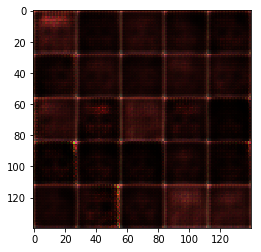

Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.9383
Epoch 1/1... Discriminator Loss: 1.0507... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 0.8864
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 1.2595
Epoch 1/1... Discriminator Loss: 1.7711... Generator Loss: 1.6428
Epoch 1/1... Discriminator Loss: 1.0760... Generator Loss: 1.0382
Epoch 1/1... Discriminator Loss: 1.4858... Generator Loss: 1.5127
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.6436... Generator Loss: 1.3162
Epoch 1/1... Discriminator Loss: 1.6390... Generator Loss: 1.8984


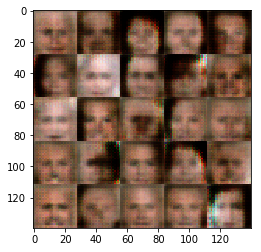

Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 1.2640
Epoch 1/1... Discriminator Loss: 1.2770... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 1.7897... Generator Loss: 1.7561
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 1.0838
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 1.9013
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 0.5222
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.6136
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.9624
Epoch 1/1... Discriminator Loss: 1.5117... Generator Loss: 1.4106


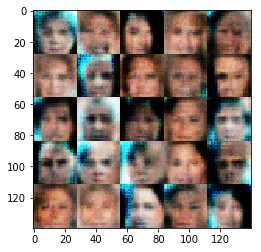

Epoch 1/1... Discriminator Loss: 1.5659... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.9819
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 0.9207
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 1.0782
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.6055... Generator Loss: 0.5728
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 1.0246
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.6174
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.6375


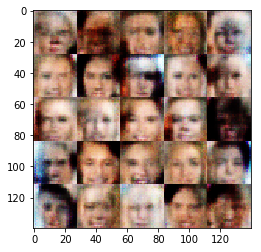

Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 1.2216... Generator Loss: 0.9488
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.5207
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.9880
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.8646
Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.9160


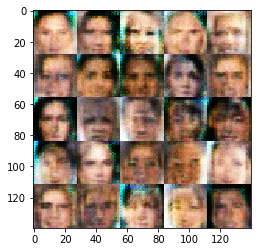

Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 1.0909
Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 1.2345... Generator Loss: 1.0366
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 1.1086
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.9801
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 0.7760


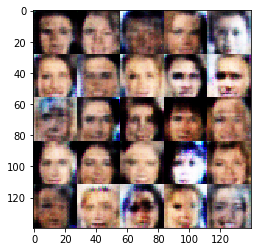

Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 1.0384
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 1.3226
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.5717
Epoch 1/1... Discriminator Loss: 1.5033... Generator Loss: 0.4523
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.2039... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.6137


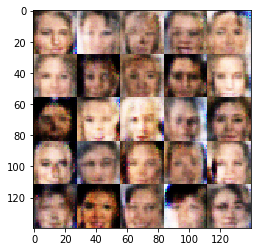

Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.8875
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 1.1168
Epoch 1/1... Discriminator Loss: 1.1395... Generator Loss: 0.9636
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 1.2505
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.9756
Epoch 1/1... Discriminator Loss: 1.5555... Generator Loss: 0.5738
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.8121


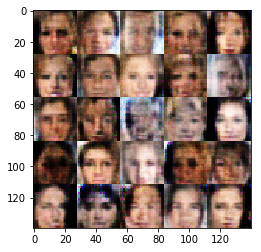

Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 1.0500
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.9155
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.6236... Generator Loss: 1.5287
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 0.8544
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.6201
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.6541


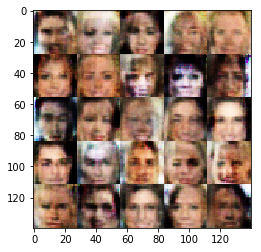

Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 1.1397
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 1.1390
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 0.9271
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.5332


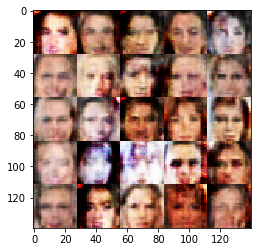

Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 1.0722
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.5530
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 1.0116
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.6201
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 1.1825
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.9442
Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 0.6100
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.6207
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.8774


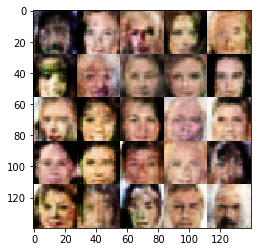

Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.8610
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 1.0231
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.5735
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.9578
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.8563
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.5849
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 1.0118
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.8865


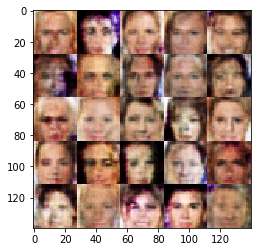

Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 1.2201
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 1.0493
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 0.9922
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.4854... Generator Loss: 1.0133
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 1.0233


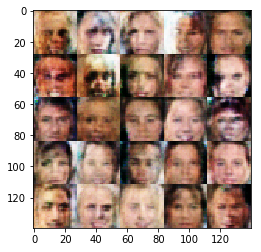

Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 1.1012
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.8949
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.8746
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.6831


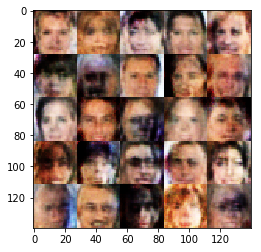

Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.9974
Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 0.5108
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 1.0292
Epoch 1/1... Discriminator Loss: 1.5594... Generator Loss: 0.4543
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 0.9338
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.5576
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.8885


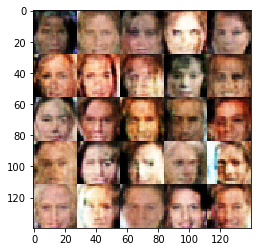

Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.9258
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 1.2875
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 1.1641
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.6396
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.7664


IndexError: list index out of range

In [255]:
batch_size = 128
z_dim = 64
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.